In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
df = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
df.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


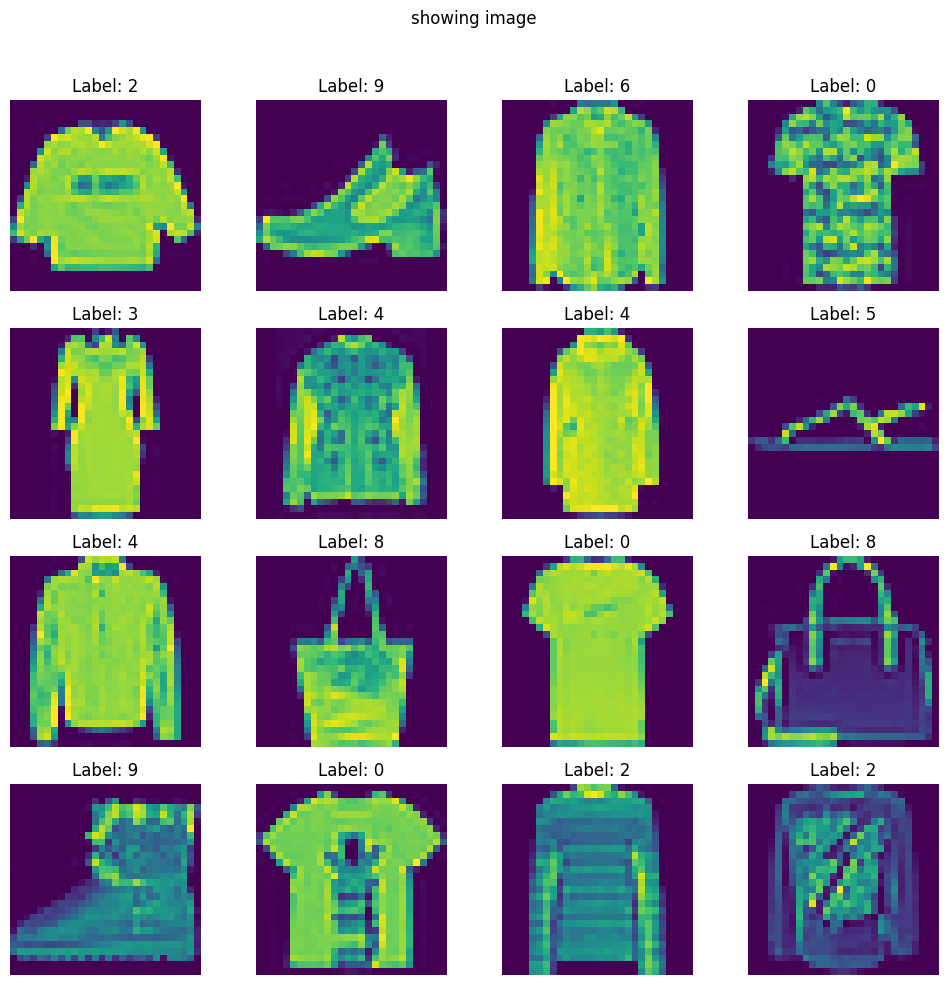

In [4]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("showing image")

for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Label: {df.iloc[i, 0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()
    

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype = torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [9]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset  = CustomDataset(X_test, y_test)

In [10]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2275,
         0.5333, 0.0000, 0.0

In [11]:
train_loader = DataLoader(train_dataset, batch_size= 128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [12]:
class FashionNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

In [13]:
model = FashionNN(num_features = X_train.shape[1])
model = model.to(device)

epochs = 100
learning_rate = 0.1
loss_function = nn.CrossEntropyLoss()
optimizer =  optim.SGD(model.parameters(), lr=learning_rate)

In [14]:
def train(num_epochs):
    best_accuracy = 0.0
    print("begin training")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0
        running_accuracy = 0.0
        total = 0

        for data in train_loader:
            batch_feat, batch_labels = data
            batch_feat, batch_labels = batch_feat.to(device), batch_labels.to(device)

            output = model(batch_feat)

            # calculate loss
            train_loss = loss_function(output, batch_labels)
            optimizer.zero_grad() # clearing the gradients

            train_loss.backward()  # backward propagation

            optimizer.step() # updating the gradients

            running_train_loss += train_loss.item()

        avg_train_loss = running_train_loss / len(train_loader)

        with torch.no_grad():
            model.eval()
            for data in test_loader:
                batch_feat, batch_labels = data
                batch_feat, batch_labels = batch_feat.to(device), batch_labels.to(device)

                prediction = model(batch_feat)
                val_loss = loss_function(prediction, batch_labels)
                _, predicted = torch.max(prediction, 1)

                running_val_loss += val_loss.item()
                total += batch_labels.size(0)

                running_accuracy += (predicted == batch_labels).sum().item()
            avg_val_loss = running_val_loss / len(test_loader)

            accuracy = (100 * running_accuracy / total)

        print(f"Epoch: {epoch}, train_loss: {avg_train_loss}, val_loss: {avg_val_loss}, Accuracy: {accuracy}")
            
        

In [15]:
train(num_epochs = epochs)

begin training
Epoch: 0, train_loss: 0.8953908202648163, val_loss: 0.5667880069702229, Accuracy: 80.26666666666667
Epoch: 1, train_loss: 0.53147243475914, val_loss: 0.526458553494291, Accuracy: 80.53333333333333
Epoch: 2, train_loss: 0.4682612252632777, val_loss: 0.44426013212254706, Accuracy: 83.75
Epoch: 3, train_loss: 0.4298185673952103, val_loss: 0.42468498488689993, Accuracy: 84.76666666666667
Epoch: 4, train_loss: 0.40255289924144744, val_loss: 0.39937592186826343, Accuracy: 85.35833333333333
Epoch: 5, train_loss: 0.379853754679362, val_loss: 0.3881717796655411, Accuracy: 85.54166666666667
Epoch: 6, train_loss: 0.3641821853717168, val_loss: 0.3813985318262526, Accuracy: 86.375
Epoch: 7, train_loss: 0.35283953126271567, val_loss: 0.3575045964185228, Accuracy: 86.81666666666666
Epoch: 8, train_loss: 0.3410923780997594, val_loss: 0.35124244017803924, Accuracy: 87.08333333333333
Epoch: 9, train_loss: 0.3293458118836085, val_loss: 0.348676343071968, Accuracy: 87.26666666666667
Epoch: 